# Basketball result prediction via modelbased machine learning
This notebook uses probablistic programming to predict the outcome of NBA games. We start with imports and loading the data.

In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 11.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd  
from matplotlib import pyplot as plt
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLowRankMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
#loading the data
dfgames = pd.read_csv('/content/drive/MyDrive/data/games/games.csv')
dfgamebox = pd.read_csv('/content/drive/MyDrive/data/games/games_details.csv',low_memory=False)
dfteampergame = pd.read_csv('/content/drive/MyDrive/data/NBAstats/Team-Stats-Per-Game.csv')

dfplayerpergame = pd.read_csv('/content/drive/MyDrive/data/NBAstats/Player-Per-Game.csv') #Only used for k-scores
dfteams = pd.read_csv('/content/drive/MyDrive/data/games/teams.csv') #Only used to clean up differences in team names between the two datasets


dfgames['GAME_DATE_EST'] = pd.to_datetime(dfgames['GAME_DATE_EST']) #Converting date to datatime for boolean comparisons
dfgames=dfgames.sort_values(by='GAME_DATE_EST',ascending=False) #sorting by game data
dfgames=dfgames.drop(range(3102,3131)) #dropping duplicates

In [6]:
#Fixing naming inconsistencies
dfgamebox.loc[dfgamebox["PLAYER_NAME"] == "OG Anunoby","PLAYER_NAME"] = "O.G. Anunoby"
dfgamebox.loc[dfgamebox["PLAYER_NAME"] == "Jeff Dowtin","PLAYER_NAME"] = "Jeff Dowtin Jr."
dfgamebox.loc[dfgamebox["PLAYER_NAME"] == "PJ Dozier","PLAYER_NAME"] = "P.J. Dozier"
dfgamebox.loc[dfgamebox["PLAYER_NAME"] == "Nicolas Claxton","PLAYER_NAME"] = "Nic Claxton"
dfgamebox.loc[dfgamebox["PLAYER_NAME"] == "Enes Kanter","PLAYER_NAME"] = "Enes Freedom"

In [7]:
dfgamebox=dfgamebox.iloc[:-550000] #Data is from 1947, dropping non-used games
dfgamebox=dfgamebox.drop(["FG_PCT","FG3_PCT","FT_PCT"],axis=1) #dropping percentages since we have also have the raw numbers.

#Converting string playing time to float
for i in range(len(dfgamebox)):   
    if isinstance(dfgamebox["MIN"].iloc[i],float):
      dfgamebox["MIN"].iloc[i]=0.0
    else:
      temp=dfgamebox["MIN"].iloc[i].split(':');
      dfgamebox["MIN"].iloc[i]=float(temp[0])+float(temp[1])/60.0


#Replacing team city which we do not use with game date
for i in range(len(dfgamebox)):   
    dfgamebox["TEAM_CITY"].iloc[i]=dfgames["GAME_DATE_EST"][dfgames["GAME_ID"] == dfgamebox["GAME_ID"].iloc[i]].item()

dfgamebox=dfgamebox.rename(columns={"TEAM_CITY": "DATE"})
dfgamebox=dfgamebox.sort_values(by='DATE',ascending=False)


<ipython-input-7-e5a7aaf83fd3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgamebox["MIN"].iloc[i]=float(temp[0])+float(temp[1])/60.0
<ipython-input-7-e5a7aaf83fd3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgamebox["MIN"].iloc[i]=0.0
<ipython-input-7-e5a7aaf83fd3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgamebox["TEAM_CITY"].iloc[i]=dfgames["GAME_DATE_EST"][dfgames["GAME_ID"] == dfgamebox["GAME_ID"].iloc[i]].

The dataframes we use for predictions consists of:

In [8]:
print('dfgames: \n',dfgames.columns)
print('dfgamebox: \n',dfgamebox.columns)
print('dfteampergame: \n',dfteampergame.columns)

dfgames: 
 Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')
dfgamebox: 
 Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'DATE', 'PLAYER_ID',
       'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM',
       'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS'],
      dtype='object')
dfteampergame: 
 Index(['season', 'lg', 'team', 'abbreviation', 'playoffs', 'g', 'mp_per_game',
       'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game',
       'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game',
       'x2p_percent', 'ft_per_game', 'fta_per_game', 'ft_percent',
       'o

For the first model, A baseline Bayesian logistic regression, we train on seasons 2015-2020 and we always test on season 2021.

In [ ]:
training_games=dfgames[(dfgames["SEASON"] == 2015) |(dfgames["SEASON"] == 2016) |(dfgames["SEASON"] == 2017) |(dfgames["SEASON"] == 2018) | (dfgames["SEASON"] == 2019) | (dfgames["SEASON"] == 2020)]
testing_games=dfgames[(dfgames["SEASON"] == 2021)]

We want to utilize the detailed stats for each player, however the amount of time played in each match varies a lot. To show this we plot a histogram of time played per played.

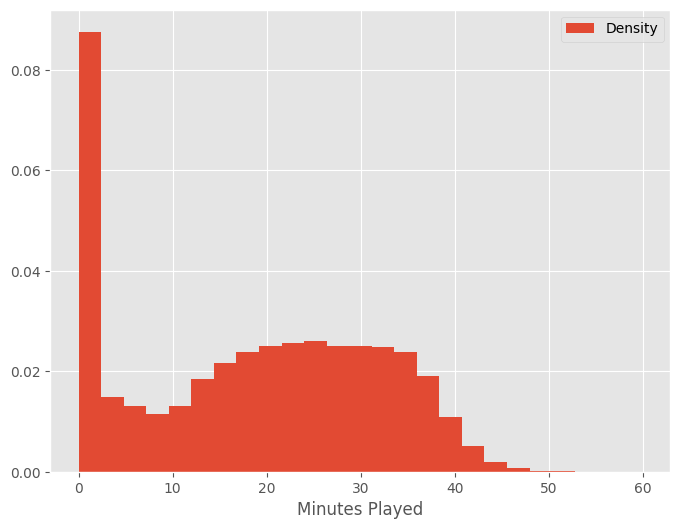

In [ ]:
plt.hist(dfgamebox["MIN"],density=True,bins=25)
x=np.arange(np.min(dfgamebox["MIN"]),np.max(dfgamebox["MIN"]))
plt.legend(["Density",])
plt.xlabel('Minutes Played')
plt.show()

Next we plot the distribution of k-scores per game for our test games. I.e. the mean squared difference between each player's minutes played and their last season average.

In [ ]:
testing_games["HOME_TEAM_K"] = 0
testing_games["AWAY_TEAM_K"] = 0

In [ ]:
#Looping over every test game
i=0
for index, row in testing_games.iterrows():
    box = dfgamebox[dfgamebox["GAME_ID"] == row["GAME_ID"]]
    home = box[box["TEAM_ID"] == row["HOME_TEAM_ID"]]
    away = box[box["TEAM_ID"] == row["VISITOR_TEAM_ID"]]

    mins_home = []
    #Looping over every player on the home team
    for p in home["PLAYER_NAME"]:
        if np.sum((dfplayerpergame["SEASON"] == row["SEASON"]-1) & (dfplayerpergame["PLAYER_NAME"] == p)) >= 1:
          mins_home.append(dfplayerpergame[(dfplayerpergame["SEASON"] == row["SEASON"]-1) & (dfplayerpergame["PLAYER_NAME"] == p)]["MIN"].values[0])
        else: #If they did not play last season:
          mins_home.append(0.0)
    k_score = np.mean((mins_home - home["MIN"])**2)  #computing the k-score
    testing_games.at[index,"HOME_TEAM_K"] = k_score

    mins_away = []
    #Every player on the away team
    for p in away["PLAYER_NAME"]:
        if np.sum((dfplayerpergame["SEASON"] == row["SEASON"]-1) & (dfplayerpergame["PLAYER_NAME"] == p)) >= 1:
          mins_away.append(dfplayerpergame[(dfplayerpergame["SEASON"] == row["SEASON"]-1) & (dfplayerpergame["PLAYER_NAME"] == p)]["MIN"].values[0])
        else:
          mins_away.append(0.0)
    k_score = np.mean((mins_away - away["MIN"])**2)
    testing_games.at[index,"AWAY_TEAM_K"] = k_score

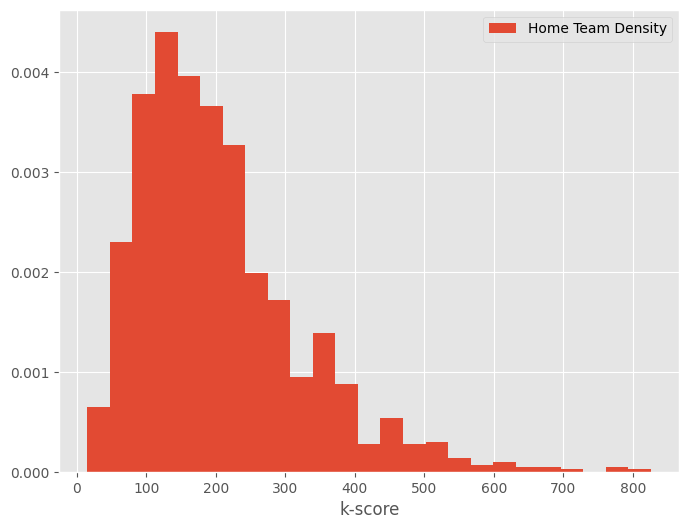

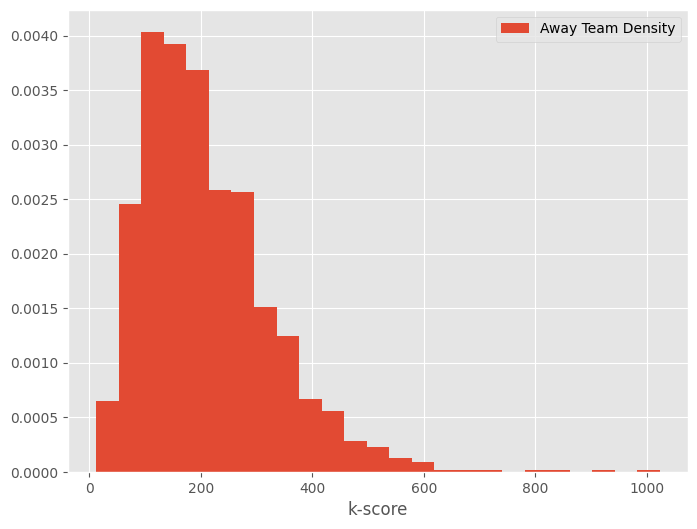

In [ ]:
plt.hist(testing_games["HOME_TEAM_K"],density=True,bins=25)
plt.legend(["Home Team Density",])
plt.xlabel('k-score')
plt.show()

plt.hist(testing_games["AWAY_TEAM_K"],density=True,bins=25)
plt.legend(["Away Team Density",])
plt.xlabel('k-score')
plt.show()

# Bayesian Logistic Regression

Now we prep the data for Bayesian Logistic Regression, we start with inputting the goal differences of each team for the last 10 matches.

In [ ]:
home_stats=[]
away_stats=[]
#We loop over all training games and compute the differences in goals for eatch match.
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_date=training_games["GAME_DATE_EST"].iloc[i]

         #find the last 10 games
         home_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == home_id)	| (dfgames["VISITOR_TEAM_ID"] == home_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10) 
         away_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == away_id)	| (dfgames["VISITOR_TEAM_ID"] == away_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10) 
         
         #Ensure correct sign for home and away team
         idx_home,idx_away=((home_matches["HOME_TEAM_ID"] == home_id).values).astype(int),((away_matches["HOME_TEAM_ID"] == away_id).values).astype(int)
         idx_home[idx_home == 0] = -1
         idx_away[idx_away == 0] = -1


         home_stats.append(( (home_matches["PTS_home"]-home_matches["PTS_away"]) *idx_home).values) 
         away_stats.append(( (away_matches["PTS_home"]-away_matches["PTS_away"]) *idx_away).values) 

home_stats_test=[]
away_stats_test=[]
#Exact same thing for the test games
for i in range(len(testing_games)):
         home_id,away_id=testing_games["HOME_TEAM_ID"].iloc[i],testing_games["VISITOR_TEAM_ID"].iloc[i]
         game_date=testing_games["GAME_DATE_EST"].iloc[i]
         home_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == home_id)	| (dfgames["VISITOR_TEAM_ID"] == home_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10)
         away_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == away_id)	| (dfgames["VISITOR_TEAM_ID"] == away_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10)
         
         idx_home,idx_away=((home_matches["HOME_TEAM_ID"] == home_id).values).astype(int),((away_matches["HOME_TEAM_ID"] == away_id).values).astype(int)
         idx_home[idx_home == 0] = -1
         idx_away[idx_away == 0] = -1

         home_stats_test.append(( (home_matches["PTS_home"]-home_matches["PTS_away"]) *idx_home).values) 
         away_stats_test.append(( (away_matches["PTS_home"]-away_matches["PTS_away"]) *idx_away).values) 

In [ ]:
#Converting everything to tensors for Pyro
home_stats=torch.tensor(home_stats).float()
away_stats=torch.tensor(away_stats).float()

home_stats_test=torch.tensor(home_stats_test).float()
away_stats_test=torch.tensor(away_stats_test).float()

#Adding ones for the bias term
X=torch.cat((torch.ones(len(home_stats),1),home_stats,away_stats),dim=1)
X_test=torch.cat((torch.ones(len(home_stats_test),1),home_stats_test,away_stats_test),dim=1)

#Match outcomes
y=torch.tensor(training_games["HOME_TEAM_WINS"].values).float()
y_test=torch.tensor(testing_games["HOME_TEAM_WINS"].values).float()

Now we have the data, next we implement and train the model in Pyro.
The generative process is:


In [ ]:
def log_regress(X, obs=None):
    #Parameters
    with pyro.plate("param", X.shape[1]):
         alpha=pyro.sample("alpha", dist.Beta(10,10))
         beta = pyro.sample("beta", dist.Normal(0, 1.0/alpha))

    #Clasification
    with pyro.plate("data", len(X)):
        y=pyro.sample("y", dist.Bernoulli(torch.sigmoid(torch.matmul(X,beta))), obs=obs)
  
    return torch.sigmoid(torch.matmul(X,beta))

In [ ]:
# Define guide function
guide =AutoMultivariateNormal(log_regress)
# Reset parameter values
pyro.clear_param_store()

In [ ]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer with learning rate decay
initial_lr = 0.01
gamma = 0.01
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(log_regress, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 58007.5
[500] ELBO: 5786.0
[1000] ELBO: 5336.7
[1500] ELBO: 5309.4
[2000] ELBO: 5326.3
[2500] ELBO: 5316.0
[3000] ELBO: 5307.2
[3500] ELBO: 5307.1
[4000] ELBO: 5305.8
[4500] ELBO: 5304.4
[5000] ELBO: 5306.9
[5500] ELBO: 5307.3
[6000] ELBO: 5301.7
[6500] ELBO: 5306.3
[7000] ELBO: 5302.4
[7500] ELBO: 5304.2
[8000] ELBO: 5303.4
[8500] ELBO: 5302.4
[9000] ELBO: 5302.7
[9500] ELBO: 5300.8


We can make predictions for the test set using Pyros Predictive.

In [ ]:
predictive = Predictive(log_regress, guide=guide, num_samples=1000,
                        return_sites=("beta","y","_RETURN"))
samples = predictive(X_test)

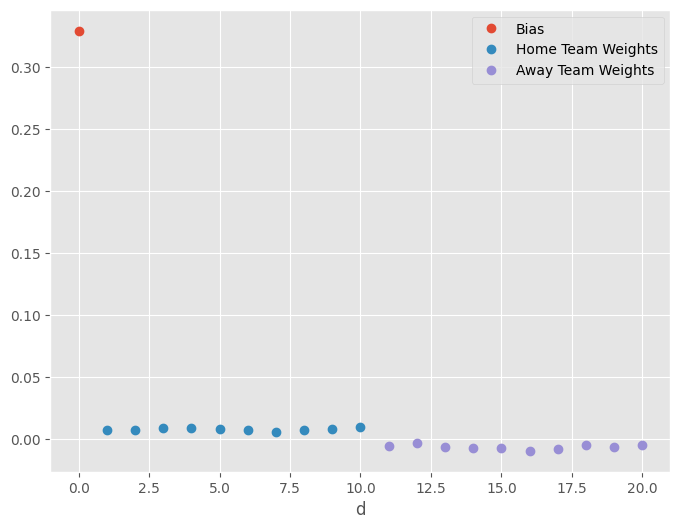

In [ ]:
#Plotting the means of the parameters
plt.plot(0,samples["beta"].mean(axis=0)[0],'o')
plt.plot(range(1,11),samples["beta"].mean(axis=0)[1:11],'o')
plt.plot(range(11,21),samples["beta"].mean(axis=0)[11:],'o')
plt.legend(["Bias","Home Team Weights","Away Team Weights"])
plt.xlabel('d')
plt.show()

In [ ]:
#Compute mean of the samples
y_pred=samples["_RETURN"].mean(axis=0)
#Compare to actual results
print('MSE:', torch.mean((y_pred - y_test)**2))

print('5%, 25%, 75% and 95% quantile:', torch.quantile(y_pred,torch.tensor([0.05,0.25,0.75,0.95])) )

#Compute Accuracy
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] =0 

#Compare to actual results
print('Accuracy:', torch.mean((y_pred == y_test).float()))

MSE: tensor(0.2301)
5%, 25%, 75% and 95% quantile: tensor([0.3118, 0.4668, 0.6864, 0.8052])
Accuracy: tensor(0.6148)


Now instead of the recent goal differences, we try to input last season team averages. We start with preparing the data




In [ ]:
#Fixing some naming inconsistencies between the two datasets
dfteampergame=dfteampergame.replace(to_replace="CHA",value="CHO")
dfteams=dfteams.replace(to_replace=["BKN","CHA","PHX"],value=["BRK","CHO","PHO"])

dfteampergame=dfteampergame.loc[dfteampergame["team"] != "League Average",:]
dfteampergame=dfteampergame.replace(to_replace=dfteams["ABBREVIATION"].tolist(),value=dfteams["TEAM_ID"].tolist())
dfteampergame=dfteampergame.rename(columns={"abbreviation": "TEAM_ID"})

In [ ]:
dfteampergame.columns

Index(['season', 'lg', 'team', 'TEAM_ID', 'playoffs', 'g', 'mp_per_game',
       'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game',
       'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game',
       'x2p_percent', 'ft_per_game', 'fta_per_game', 'ft_percent',
       'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game',
       'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game',
       'pts_per_game'],
      dtype='object')

In [ ]:
#Looping over training games
home_ls=[]
away_ls=[]
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         season=training_games["SEASON"].iloc[i]

         #Extracting last season data, points per game, steals per game, total rebounds per game and assists per game
         home_ls.append(dfteampergame[(dfteampergame["TEAM_ID"] == home_id) & (dfteampergame["season"] == season-1)][["pts_per_game","stl_per_game","trb_per_game","ast_per_game"]].values)
         away_ls.append(dfteampergame[(dfteampergame["TEAM_ID"] == away_id) & (dfteampergame["season"] == season-1)][["pts_per_game","stl_per_game","trb_per_game","ast_per_game"]].values)

home_ls_test=[]
away_ls_test=[]
#Same loop now for the test games
for i in range(len(testing_games)):
         home_id,away_id=testing_games["HOME_TEAM_ID"].iloc[i],testing_games["VISITOR_TEAM_ID"].iloc[i]
         season=testing_games["SEASON"].iloc[i]

         home_ls_test.append(dfteampergame[(dfteampergame["TEAM_ID"] == home_id) & (dfteampergame["season"] == season-1)][["pts_per_game","stl_per_game","trb_per_game","ast_per_game"]].values)
         away_ls_test.append(dfteampergame[(dfteampergame["TEAM_ID"] == away_id) & (dfteampergame["season"] == season-1)][["pts_per_game","stl_per_game","trb_per_game","ast_per_game"]].values)


In [ ]:
#Converting the data to tensors for pyro
home_ls=torch.squeeze(torch.tensor(home_ls).float())
away_ls=torch.squeeze(torch.tensor(away_ls).float())

home_ls_test=torch.squeeze(torch.tensor(home_ls_test).float())
away_ls_test=torch.squeeze(torch.tensor(away_ls_test).float())

#Add ones for bias term
X=torch.cat((torch.ones(len(home_ls),1),home_ls,away_ls),dim=1)
X_test=torch.cat((torch.ones(len(home_ls_test),1),home_ls_test,away_ls_test),dim=1)

In [ ]:
#Model and guide is exactly the same as before
guide =AutoMultivariateNormal(log_regress)

# Reset parameter values
pyro.clear_param_store()

In [ ]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
initial_lr = 0.01
gamma = 0.01
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(log_regress, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 54876.8
[500] ELBO: 73333.1
[1000] ELBO: 12761.9
[1500] ELBO: 11749.9
[2000] ELBO: 9429.3
[2500] ELBO: 8430.5
[3000] ELBO: 7318.3
[3500] ELBO: 9072.1
[4000] ELBO: 6958.7
[4500] ELBO: 7963.7
[5000] ELBO: 6770.5
[5500] ELBO: 6052.2
[6000] ELBO: 6353.9
[6500] ELBO: 6908.1
[7000] ELBO: 7622.0
[7500] ELBO: 6098.8
[8000] ELBO: 7025.1
[8500] ELBO: 5934.7
[9000] ELBO: 6597.8
[9500] ELBO: 5762.4


In [ ]:
#Again predictive for the test data
predictive = Predictive(log_regress, guide=guide, num_samples=1000,
                        return_sites=("beta","y","_RETURN"))
samples = predictive(X_test)

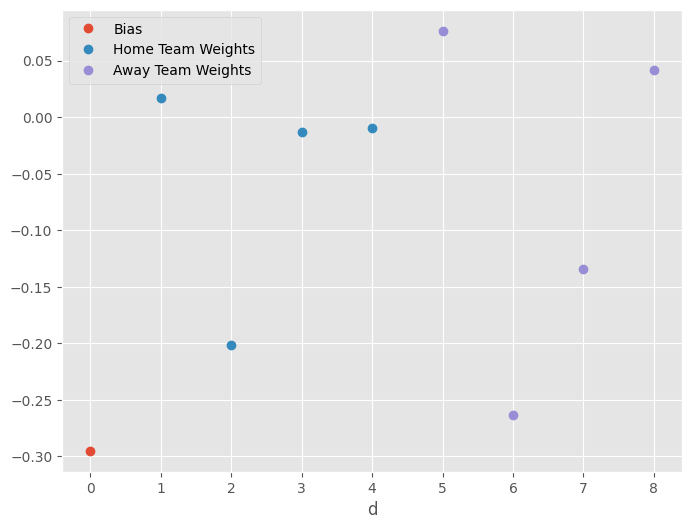

In [ ]:
#Plotting the means of the weights of the parameters
plt.plot(0,samples["beta"].mean(axis=0)[0],'o')
plt.plot(range(1,5),samples["beta"].mean(axis=0)[1:5],'o')
plt.plot(range(5,9),samples["beta"].mean(axis=0)[5:],'o')
plt.legend(["Bias","Home Team Weights","Away Team Weights"])
plt.xlabel('d')
plt.show()

In [ ]:
#Compute mean of the samples
y_pred=samples["_RETURN"].mean(axis=0)
#Compare to actual results
print('MSE:', torch.mean((y_pred - y_test)**2))

print('5%, 25%, 75% and 95% quantile:', torch.quantile(y_pred,torch.tensor([0.05,0.25,0.75,0.95])) )

#Compute Accuracy
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] =0 

#Compare to actual results
print('Accuracy:', torch.mean((y_pred == y_test).float()))


print('Fraction of home team wins predicted:', torch.sum(y_pred)/len(y_pred))

MSE: tensor(0.2629)
5%, 25%, 75% and 95% quantile: tensor([0.5348, 0.6239, 0.7168, 0.7662])
Accuracy: tensor(0.5508)
Fraction of home team wins predicted: tensor(0.9820)


# The Full Model - individual Player performances based on current form

The full model consists of 3 submodels. the first is logistic regression to determine which players are utilized in each game. The second is a mix of classification and mixture models and it determines playing time for each player who plays. The third submodel used neural networks and Terry-Bradley to model the outcome of each game.

In [9]:
#We now only train on season 2020
training_games=dfgames[(dfgames["SEASON"] == 2020)]
testing_games=dfgames[(dfgames["SEASON"] == 2021)]

We compute the NBA mean per minutes per player for all statistics given in dfgamebox.

In [ ]:
#A dataset only consisting of players with more than 10 minutes of playing time
dfgamebox_fix=dfgamebox[dfgamebox["MIN"] >= 10]
mean=np.mean(dfgamebox_fix.iloc[:,10:].values/dfgamebox_fix.iloc[:,9].values[:,None],axis=0).astype('float')

We prepare two matrices of player per minute stats for each player in each game, one for the home team and one for the away team.

In [ ]:
home_cur=[]
away_cur=[]
#Looping over training games
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_id=training_games["GAME_ID"].iloc[i]
         game_date=training_games["GAME_DATE_EST"].iloc[i]

         game_home=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==home_id)]
         game_away=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==away_id)]

         #Looping over players on home team
         for j in range(len(game_home)):
            player=game_home["PLAYER_NAME"].iloc[j]
            #if they have 3 games with more than 10 minutes use the mean statistics from those games, otherwise use the overall NBA mean
            if np.sum( (dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d') )) >= 3:
              temp=dfgamebox_fix[(dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(5)
              home_cur.append(np.mean(temp.iloc[:,10:].values/temp.iloc[:,9].values[:,None],axis=0).astype('float'))
            else:
              home_cur.append(mean)

        #Same Loop over players on away team
         for j in range(len(game_away)):
            player=game_away["PLAYER_NAME"].iloc[j]
            if np.sum( (dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d') )) >= 3:
              temp=dfgamebox_fix[(dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(5)
              away_cur.append(np.mean(temp.iloc[:,10:].values/temp.iloc[:,9].values[:,None],axis=0).astype('float'))
            else:
              away_cur.append(mean)

home_cur=torch.tensor(home_cur).float()
away_cur=torch.tensor(away_cur).float()

In [ ]:
#Preparing the same data for the testing games
home_cur_test=[]
away_cur_test=[]
for i in range(len(testing_games)):
         home_id,away_id=testing_games["HOME_TEAM_ID"].iloc[i],testing_games["VISITOR_TEAM_ID"].iloc[i]
         game_id=testing_games["GAME_ID"].iloc[i]
         game_date=testing_games["GAME_DATE_EST"].iloc[i]

         game_home=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==home_id)]
         game_away=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==away_id)]

         for j in range(len(game_home)):
            player=game_home["PLAYER_NAME"].iloc[j]
            if np.sum( (dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d') )) >= 3:
              temp=dfgamebox_fix[(dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(5)
              home_cur_test.append(np.mean(temp.iloc[:,10:].values/temp.iloc[:,9].values[:,None],axis=0).astype('float'))
            else:
              home_cur_test.append(mean)

         for j in range(len(game_away)):
            player=game_away["PLAYER_NAME"].iloc[j]
            if np.sum( (dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d') )) >= 3:
              temp=dfgamebox_fix[(dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(5)
              away_cur_test.append(np.mean(temp.iloc[:,10:].values/temp.iloc[:,9].values[:,None],axis=0).astype('float'))
            else:
              away_cur_test.append(mean)

home_cur_test=torch.tensor(home_cur_test).float()
away_cur_test=torch.tensor(away_cur_test).float()

Now, we prepare a matrix of minutes played in the last three games for each player in each game.

In [ ]:
home_time=[]
away_time=[]

home_y_time=[]
away_y_time=[]
len_home=[]
len_away=[]

#Looping over each games
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_id=training_games["GAME_ID"].iloc[i]
         game_date=training_games["GAME_DATE_EST"].iloc[i]

         game_home=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==home_id)]
         game_away=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==away_id)]

        #Storing minutes in actual game
         home_y_time.append(game_home["MIN"].values.astype('float'))
         away_y_time.append(game_away["MIN"].values.astype('float'))

         #Storing the amount of players each team brought to the match, used for indexing later
         len_home.append(len(game_home)) 
         len_away.append(len(game_away))

         #Loop to find the last 3 games for each player, if they do not have 3 games within the last year, zeros are added instead.
         for j in range(len(game_home)):
            player=game_home["PLAYER_NAME"].iloc[j]
            temp=dfgamebox[(dfgamebox["PLAYER_NAME"] == player) & (dfgamebox["DATE"] < game_date) &  (dfgamebox["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(3) 
            if len(temp) < 3:
              home_time.append(np.concatenate((temp["MIN"].values,np.zeros(3-len(temp))) ).astype('float') )
            else:
              home_time.append(temp["MIN"].values.astype('float'))

         #Same for away etam
         for j in range(len(game_away)):
            player=game_away["PLAYER_NAME"].iloc[j]
            temp=dfgamebox[(dfgamebox["PLAYER_NAME"] == player) & (dfgamebox["DATE"] < game_date) &  (dfgamebox["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(3)
            if len(temp) < 3:
              away_time.append(np.concatenate((temp["MIN"].values,np.zeros(3-len(temp))) ).astype('float') )
            else:
              away_time.append(temp["MIN"].values.astype('float'))

home_time=torch.tensor(home_time).float()
away_time=torch.tensor(away_time).float()

home_y_time=torch.tensor(np.concatenate( home_y_time, axis=0 )).float()
away_y_time=torch.tensor(np.concatenate( away_y_time, axis=0 )).float()

len_home=torch.tensor(len_home).long()
len_away=torch.tensor(len_away).long()

In [ ]:
#Same loop for test games
home_time_test=[]
away_time_test=[]

home_y_time_test=[]
away_y_time_test=[]
len_home_test=[]
len_away_test=[]
for i in range(len(testing_games)):
         home_id,away_id=testing_games["HOME_TEAM_ID"].iloc[i],testing_games["VISITOR_TEAM_ID"].iloc[i]
         game_id=testing_games["GAME_ID"].iloc[i]
         game_date=testing_games["GAME_DATE_EST"].iloc[i]

         game_home=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==home_id)]
         game_away=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==away_id)]

         home_y_time_test.append(game_home["MIN"].values.astype('float'))
         away_y_time_test.append(game_away["MIN"].values.astype('float'))

         len_home_test.append(len(game_home))
         len_away_test.append(len(game_away))

         for j in range(len(game_home)):
            player=game_home["PLAYER_NAME"].iloc[j]
            temp=dfgamebox[(dfgamebox["PLAYER_NAME"] == player) & (dfgamebox["DATE"] < game_date) &  (dfgamebox["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(3) 
            if len(temp) < 3:
              home_time_test.append(np.concatenate((temp["MIN"].values,np.zeros(3-len(temp))) ).astype('float') )
            else:
              home_time_test.append(temp["MIN"].values.astype('float'))


         for j in range(len(game_away)):
            player=game_away["PLAYER_NAME"].iloc[j]
            temp=dfgamebox[(dfgamebox["PLAYER_NAME"] == player) & (dfgamebox["DATE"] < game_date) &  (dfgamebox["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(3)
            if len(temp) < 3:
              away_time_test.append(np.concatenate((temp["MIN"].values,np.zeros(3-len(temp))) ).astype('float') )
            else:
              away_time_test.append(temp["MIN"].values.astype('float'))

home_time_test=torch.tensor(home_time_test).float()
away_time_test=torch.tensor(away_time_test).float()

home_y_time_test=torch.tensor(np.concatenate( home_y_time_test, axis=0 )).float()
away_y_time_test=torch.tensor(np.concatenate( away_y_time_test, axis=0 )).float()

len_home_test=torch.tensor(len_home_test).long()
len_away_test=torch.tensor(len_away_test).long()

In [11]:
home_time=torch.load('home_time.pt')
away_time=torch.load('away_time.pt')
home_y_time=torch.load('home_y_time.pt')
away_y_time=torch.load('away_y_time.pt')
len_home=torch.load('len_home.pt')
len_away=torch.load('len_away.pt')
home_cur=torch.load('home_cur.pt')
away_cur=torch.load('away_cur.pt')

In [12]:
#A binary variable that is 1 if the player plays in the game
#They need to be floats due to Pyro mechanics
home_y_bin=(home_y_time > 0).float()
away_y_bin=(away_y_time > 0).float()

Now we have the data, we move on to coding the models. We start with submodel 1 which is logistic regression to determine which player plays based on their playing time in the last three games.

In [13]:
def play_model(X1,X2,obs1=None,obs2=None):
      #parameters
      b = pyro.sample("b", dist.Normal(0.0,10))
      alpha=pyro.sample("alpha", dist.Gamma(10*torch.ones(X1.shape[1]), 10*torch.ones(X1.shape[1])).to_event())  
      beta = pyro.sample("beta", dist.Normal(torch.zeros(X1.shape[1]), 1/alpha).to_event())  
      
      #plate over home players, needs to be separated due to different player lengths
      with pyro.plate("player1", X1.shape[0]):
          z1=pyro.sample("z1", dist.Bernoulli(torch.sigmoid(torch.matmul(X1,beta)+b)), obs =obs1)

      #plate over away players
      with pyro.plate("players", X2.shape[0]):    
          z2=pyro.sample("z2", dist.Bernoulli(torch.sigmoid(torch.matmul(X2,beta)+b)), obs =obs2) 

In [14]:
#Define guide
guide=AutoMultivariateNormal(play_model)

#Clear parameters
pyro.clear_param_store()

In [15]:
n_steps = 10000

# Setup the optimizer
initial_lr = 0.01
gamma = 0.01
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(play_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(home_time,away_time,home_y_bin,away_y_bin)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 110435.7
[500] ELBO: 12866.4
[1000] ELBO: 12093.8
[1500] ELBO: 12051.9
[2000] ELBO: 12062.5
[2500] ELBO: 12062.7
[3000] ELBO: 12056.4
[3500] ELBO: 12059.3
[4000] ELBO: 12053.3
[4500] ELBO: 12055.0
[5000] ELBO: 12054.7
[5500] ELBO: 12056.9
[6000] ELBO: 12054.1
[6500] ELBO: 12055.8
[7000] ELBO: 12054.3
[7500] ELBO: 12054.2
[8000] ELBO: 12055.0
[8500] ELBO: 12054.5
[9000] ELBO: 12055.1
[9500] ELBO: 12054.3


We store the predictive now before using it, since we clear the parameters later.

In [16]:
predictive_play = Predictive(play_model, guide=guide, num_samples=1000,
                        return_sites=("z1","z2"))

Next is submodel 2, which models the amount of time each player plays. It classifies each player into 

In [20]:
def time_model(X1,X2,obs1=None,obs2=None):
      #Draw classification weights
      alpha = pyro.sample("alpha", dist.Normal(0.0,10))
      beta = pyro.sample("beta", dist.Normal(torch.zeros(X1.shape[1]), 10*torch.ones(X1.shape[1])).to_event())  
     
      #Draw exponential and gamma parameters
      rate = pyro.sample('rate', dist.HalfCauchy(20.0))
      concentration = pyro.sample('concentration', dist.HalfCauchy(20.0))
      rate2  = pyro.sample('rate2', dist.HalfCauchy(1.0))

      #Classification plates, again separate for home and away
      with pyro.plate("player", X1.shape[0]):
          y1=pyro.sample("y1", dist.Bernoulli(torch.sigmoid(torch.matmul(X1,beta)+alpha)), infer={"enumerate": "parallel"})

      with pyro.plate("players2", X2.shape[0]):
          y2=pyro.sample("y2", dist.Bernoulli(torch.sigmoid(torch.matmul(X2,beta)+alpha)), infer={"enumerate": "parallel"})
     
      #Drawing time using masked mixture which draws from the two different distributions depending on the mask. The seperate plates are neccessary due to the mechanics of enumeration in Pyro.
      with pyro.plate("min", X1.shape[0]):
          minutes1 = pyro.sample('obs1', dist.MaskedMixture(y1 == 1,dist.Exponential(rate),dist.Gamma(concentration,rate2)), obs=obs1)

      with pyro.plate("min2", X2.shape[0]):   
          minutes2 = pyro.sample('obs2', dist.MaskedMixture(y2 == 1,dist.Exponential(rate),dist.Gamma(concentration,rate2)), obs=obs2)

In [21]:
#Selecting only the subset of players that plays
home_time_nz=home_time[home_y_bin==1,:]
away_time_nz=away_time[away_y_bin==1,:]

home_y_nz=home_y_time[home_y_bin==1]
away_y_nz=away_y_time[away_y_bin==1]

In [22]:
#Run MCMC, no SVI due to enumeration
nuts_kernel = NUTS(time_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=2)

mcmc.run(home_time_nz,away_time_nz,home_y_nz,away_y_nz)

# Show summary of inference results
mcmc.summary()

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]: 100%|██████████| 600/600 [09:56,  1.01it/s, step size=1.97e-01, acc. prob=0.824]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          alpha     13.58      5.32     12.43      6.38     21.62    179.40      1.00
        beta[0]      7.92      5.84      6.92     -0.26     16.70     12.28      1.17
        beta[1]      7.99      5.89      7.15     -0.44     15.81    124.29      1.01
        beta[2]      7.44      5.39      6.27     -0.14     15.22     82.64      1.04
  concentration      2.52      0.02      2.52      2.49      2.55    373.24      1.00
           rate    109.49    717.38     20.71      0.15    129.89    297.42      1.00
          rate2      0.11      0.00      0.11      0.11      0.11    369.81      1.00

Number of divergences: 626


n_eff and r_hat looks pretty good. Number of divergences is a cause for concern however.

Next we move onto the third and final submodel which predicts the outcome of each game using neural networks. We start by preparing the data which means extracting rebounds, assists, steals, points and plus-minus stats from the player per minutes matrix and elementwise multiplying it with the minutes played for each player. Then we sum over all players for both the home and away team to have the expected performance output for each team. 

The approach for summing over each team is not the most readable, however it is fast and speed is needed since we need to do it for each sample when making predictions later.

In [ ]:
home_output=home_cur[:,[8,9,10,14,15]]*home_y_time[:,None]
away_output=away_cur[:,[8,9,10,14,15]]*away_y_time[:,None]

#Summing over each team
home_output=torch.cat(list(map(lambda x: torch.sum(x,dim=0), torch.split(home_output,tuple(len_home)) )),dim=0).reshape((-1,5))
away_output=torch.cat(list(map(lambda x: torch.sum(x,dim=0), torch.split(away_output,tuple(len_away)) )),dim=0).reshape((-1,5))

#Training match results
y=torch.tensor(training_games["HOME_TEAM_WINS"].values).float()

Now we can define the model in pyro, it consists of two neural networks, one for the home team and one for the away team. We found this was the best way to model incorporate home team advantage. Each network has a sigmoid activation function in the final layer and then the output is used in the Bradley-Terry model.

In [ ]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class predict_NN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(predict_NN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0)).expand([n_out, n_hidden]).to_event(2))

        self.in_layer2 = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer2 = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0)).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X1,X2, obs=None):
        #Feed home team through network
        X1= self.tanh(self.in_layer(X1))
        X1 = self.tanh(self.h_layer(X1))
        X1 = self.sigmoid((self.out_layer(X1)))
        prob1 = X1.squeeze(-1)

        #Feed away team through network
        X2= self.tanh(self.in_layer2(X2))
        X2 = self.tanh(self.h_layer2(X2))
        X2 = self.sigmoid((self.out_layer2(X2)))
        prob2 = X2.squeeze(-1)

        #Bradley-Terry
        with pyro.plate("observations"):
            y = pyro.sample("y", dist.Bernoulli(prob1/(prob1+prob2)), obs=obs)
        return prob1/(prob1+prob2)

In [ ]:
#Define number of neurons
model_NN=predict_NN(n_in=home_output.shape[1], n_hidden=5, n_out=1)
#Define gude
guide =AutoLowRankMultivariateNormal(model_NN)

# Reset parameter values
pyro.clear_param_store()

In [ ]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
initial_lr = 0.01
gamma = 0.01
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model_NN, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(home_output, away_output,y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1188.8
[500] ELBO: 979.5
[1000] ELBO: 910.2
[1500] ELBO: 890.8
[2000] ELBO: 897.5
[2500] ELBO: 882.9
[3000] ELBO: 885.4
[3500] ELBO: 868.8
[4000] ELBO: 871.3
[4500] ELBO: 879.8
[5000] ELBO: 879.9
[5500] ELBO: 872.5
[6000] ELBO: 879.4
[6500] ELBO: 868.1
[7000] ELBO: 876.7
[7500] ELBO: 894.9
[8000] ELBO: 905.4
[8500] ELBO: 872.2
[9000] ELBO: 870.8
[9500] ELBO: 879.0


Next we define two predictive functions, one that outputs 1000 samples to test submodel 3 separately and one with only 1 sample for the three models combined.

In [ ]:
predictive_NN = Predictive(model_NN, guide=guide, num_samples=1000,
                        return_sites=("y","_RETURN"))

predictive_NN2 = Predictive(model_NN, guide=guide, num_samples=1,
                        return_sites=("y","_RETURN"))

# Predictions using only submodel 3

First, we test the case where we already know the minuted played for each player in submodel 3, this is of course not something you have before an NBA game but it allows us to test submodel 3 alone

In [ ]:
#Data preparation for test games
home_output_test=home_cur_test[:,[8,9,10,14,15]]*home_y_time_test[:,None]
away_output_test=away_cur_test[:,[8,9,10,14,15]]*away_y_time_test[:,None]
home_output_test=torch.cat(list(map(lambda x: torch.sum(x,dim=0), torch.split(home_output_test,tuple(len_home_test)) )),dim=0).reshape((-1,5))
away_output_test=torch.cat(list(map(lambda x: torch.sum(x,dim=0), torch.split(away_output_test,tuple(len_away_test)) )),dim=0).reshape((-1,5))

y_test=torch.tensor(testing_games["HOME_TEAM_WINS"].values).float()

In [ ]:
#Samples from submodel 3
samples = predictive_NN(home_output_test, away_output_test)

#Compute mean of the samples
y_pred=samples["_RETURN"].mean(axis=0)
#Compare to actual results
print('MSE:', torch.mean((y_pred - y_test)**2))

print('5%, 25%, 75% and 95% quantile:', torch.quantile(y_pred,torch.tensor([0.05,0.25,0.75,0.95])) )

#Compute Accuracy
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] =0 

#Compare to actual results
print('Accuracy:', torch.mean((y_pred == y_test).float()))

MSE: tensor(0.2392)
5%, 25%, 75% and 95% quantile: tensor([0.4892, 0.4961, 0.6027, 0.6125])
Accuracy: tensor(0.6134)


# Predictions for the full model
Finally, we can make predictions using the full model. To do this we first generate samples from the posterior predictive of the first submodel and then pass these through the next submodels, each with samples independently sampled from their respective posterior distributions.

In [ ]:
#Predictive from MCMC with only one sample
predictive_time = Predictive(time_model,posterior_samples=mcmc.get_samples(1),
                        return_sites=("obs1","obs2"))

In [ ]:
#Binary samples from the first model
samples_play=predictive_play(home_time_test,away_time_test)

home_time_samples=[]
away_time_samples=[]
#Passing the binary samples through the second submodel to obtain player times
for i in range(1000):
  samples_time2=predictive_time(home_time_test[samples_play["z1"][i,:]==1],away_time_test[samples_play["z2"][i,:]==1])
  temp_home=torch.zeros(len(home_time_test))
  temp_home[samples_play["z1"][i,:]==1]=samples_time2["obs1"]
  home_time_samples.append(temp_home)

  temp_away=torch.zeros(len(away_time_test))
  temp_away[samples_play["z2"][i,:]==1]=samples_time2["obs2"]
  away_time_samples.append(temp_away)


In [ ]:
samples_results_test=[]
for i in range(1000):
  #Computing the output
  home_output_test=home_cur_test[:,[8,9,10,14,15]]*home_time_samples[i][:,None]
  away_output_test=away_cur_test[:,[8,9,10,14,15]]*away_time_samples[i][:,None]
  home_output_test=torch.cat(list(map(lambda x: torch.sum(x,dim=0), torch.split(home_output_test,tuple(len_home_test)) )),dim=0).reshape((-1,5))
  away_output_test=torch.cat(list(map(lambda x: torch.sum(x,dim=0), torch.split(away_output_test,tuple(len_away_test)) )),dim=0).reshape((-1,5))

  #Passing player times through the third submodel to obtain predictions
  samples_results_test.append(predictive_NN2(home_output_test, away_output_test)["_RETURN"])

In [ ]:
#Compute mean of samples
y_pred=torch.cat(samples_results_test).mean(axis=0)


#Compare to actual results
print('MSE:', torch.mean((y_pred - y_test)**2))

print('5%, 25%, 75% and 95% quantile:', torch.quantile(y_pred,torch.tensor([0.05,0.25,0.75,0.95])) )

#Compute Accuracy
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] =0 

#Compare to actual results
print('Accuracy:', torch.mean((y_pred == y_test).float()))


MSE: tensor(0.2405)
5%, 25%, 75% and 95% quantile: tensor([0.4858, 0.4982, 0.5862, 0.6093])
Accuracy: tensor(0.6048)


# Exploring outputs of submodel 2

Finally we explore the output of submodel 2 and how close it resembles the real word. We start by generating only 20 samples due to memory limitations when plotting histograms due to the amount of players.

In [ ]:
#Predictive from MCMC with only one sample
predictive_time = Predictive(time_model,posterior_samples=mcmc.get_samples(1),
                        return_sites=("obs1","obs2"))

#Binary samples from the first model
samples_play=predictive_play(home_time_test,away_time_test)

home_time_samples=[]
away_time_samples=[]
#Passing the binary samples through the second submodel to obtain player times
for i in range(20):
  samples_time2=predictive_time(home_time_test[samples_play["z1"][i,:]==1],away_time_test[samples_play["z2"][i,:]==1])
  temp_home=torch.zeros(len(home_time_test))
  print(len(temp_home))
  temp_home[samples_play["z1"][i,:]==1]=samples_time2["obs1"]
  print(len(temp_home))
  home_time_samples.append(temp_home)

  temp_away=torch.zeros(len(away_time_test))
  temp_away[samples_play["z2"][i,:]==1]=samples_time2["obs2"]
  away_time_samples.append(temp_away)


Then we plot samples of minutes played for each player.

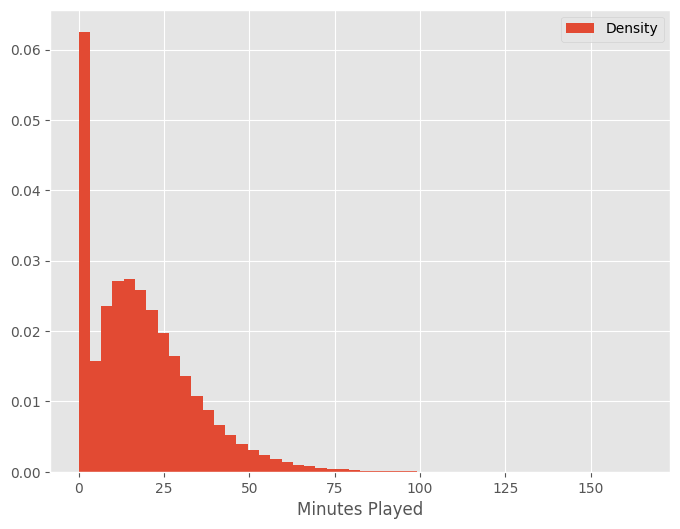

In [25]:
plt.hist(torch.cat((torch.cat((home_time_samples)),torch.cat((away_time_samples)))),density=True,bins=50)
plt.legend(["Density",])
plt.xlabel('Minutes played per player-')
plt.show()

Finally, we sum over each player in each game to obtain a total sampled gamelength.

In [57]:
total_time_home=torch.tensor(list(map(lambda x: torch.sum(x,dim=0), torch.split(torch.cat(home_time_samples),tuple(len_home_test.repeat(20) )) )))
total_time_away=torch.tensor(list(map(lambda x: torch.sum(x,dim=0), torch.split(torch.cat(away_time_samples),tuple(len_away_test.repeat(20) )) )))

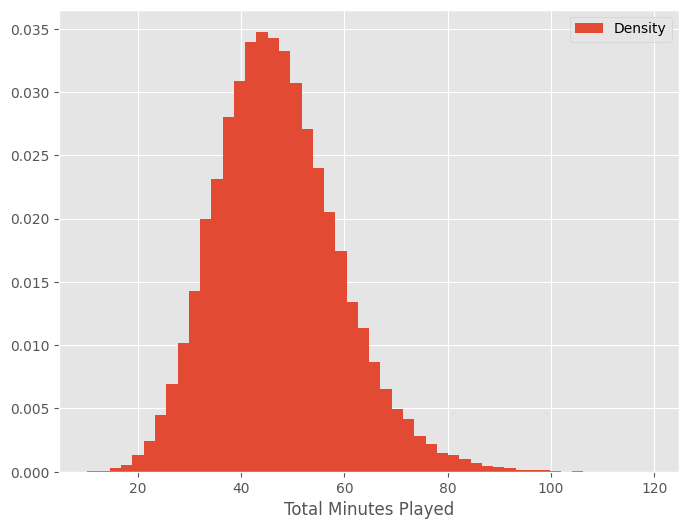

In [60]:
#Divide by 5 since there are 5 players in a match
plt.hist(torch.cat((total_time_home/5, total_time_away/5)),density=True,bins=50)
plt.legend(["Density",])
plt.xlabel('Minutes of game length')
plt.show()